In [2]:
import numpy as np
import astropy.units as u
from astroquery.gaia import Gaia
from astropy.table import Table
from gala.coordinates import reflex_correct, GD1Koposov10
from astropy.coordinates import SkyCoord


In [4]:
# define an ADQL query
#############

column_list = ['gaia.source_id',
               'gaia.ra',
               'gaia.dec',
               'gaia.pmra',
               'gaia.pmdec',
               'best.number_of_neighbours',
               'best.number_of_mates',
               'ps.g_mean_psf_mag',
               'ps.i_mean_psf_mag']

columns = ", ".join(column_list)

query_base="""
    SELECT 
    {top}
    {columns}
    FROM gaiadr3.gaia_source as gaia
    JOIN gaiadr3.panstarrs1_best_neighbour as best
        ON gaia.source_id = best.source_id
    JOIN gaiadr2.panstarrs1_original_valid as ps
        ON best.original_ext_source_id = ps.obj_id
    WHERE 
        gaia.parallax < 1
        AND gaia.bp_rp BETWEEN -0.75 AND 2
        AND 1 = CONTAINS(
            POINT(gaia.ra,gaia.dec), 
            POLYGON({polygon})
        )
"""



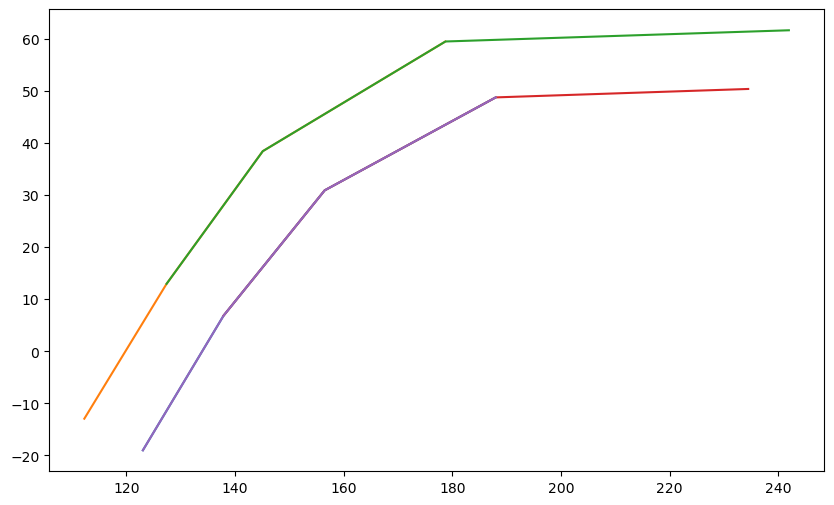

In [15]:
# define the corners of the search space
###########

from common import make_rectangle
import matplotlib.pyplot as plt
# create a series of rectangles for the query 
phi1_ranges = [(-100, -70), (-70, -40), (-40, -10), (-10, 20)] *u.deg
phi2_range = ( -8, 4)*u.deg

# make the rectangle for each range
rects = map(lambda phi1_range: make_rectangle(phi1_range, phi2_range), phi1_ranges)
# and reformat from a list of tuples to tuple of lists
rects = zip(*rects)
rects = tuple(map(list, rects))

# convert from the GD1 to ICRS frame
gd1_frame = GD1Koposov10()
gd1_corners = SkyCoord(phi1=rects[0], phi2=rects[1], frame=gd1_frame)
icrs_corners = gd1_corners.transform_to('icrs')

plt.figure(figsize=(10,6))
plt.plot(icrs_corners.ra, icrs_corners.dec)

In [ ]:
# do the query
##########

from astropy.table import Table, vstack, unique
from common import skycoords_to_string, plot_ra_dec

# accumulator table for all results
results_t = Table()

# for each corners range identified, create and execute a query
for region in icrs_corners:
    query = query_base.format(columns=columns, polygon=skycoords_to_string(region), top="TOP 500000")
    print(query)
    job = Gaia.launch_job(query)
    results = job.get_results()
    # accumuate the results
    results_t = vstack([results_t, results])
    results_t = unique(results_t, keys="source_id")




    SELECT 
    TOP 500000
    gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.number_of_neighbours, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
    FROM gaiadr3.gaia_source as gaia
    JOIN gaiadr3.panstarrs1_best_neighbour as best
        ON gaia.source_id = best.source_id
    JOIN gaiadr2.panstarrs1_original_valid as ps
        ON best.original_ext_source_id = ps.obj_id
    WHERE 
        gaia.parallax < 1
        AND gaia.bp_rp BETWEEN -0.75 AND 2
        AND 1 = CONTAINS(
            POINT(gaia.ra,gaia.dec), 
            POLYGON(123.041, -19.002, 112.264, -12.9365, 127.403, 12.9524, 137.893, 6.84216, 123.041, -19.002)
        )


    SELECT 
    TOP 500000
    gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.number_of_neighbours, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
    FROM gaiadr3.gaia_source as gaia
    JOIN gaiadr3.panstarrs1_best_neighbour as best
        ON gaia.source_id = best.source_id
    JOIN gaiadr2.pan

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [7]:
# add GD1 coordinates to each row
######

from gala.coordinates import GD1Koposov10
from gala.coordinates import reflex_correct
from common import icrs_to_gd1

# the GD1 stars are too far away for accurate parallax, so use a approximate average value for distance
distance = 8 * u.kpc
radial_velocity = 0 * u.km/u.s

# create coordinate objects for each entry in the table
skycoord_icrf = SkyCoord(ra=results_t['ra'], 
                    dec=results_t['dec'],
                    pm_ra_cosdec=results_t['pmra'],
                    pm_dec=results_t['pmdec'], 
                    distance=distance, 
                    radial_velocity=radial_velocity)

# create coresponding gd1 frame coordinate objects
skycoord_gd1 = icrs_to_gd1(skycoord_icrf)

# add these coordinates back to the results table
results_t['phi1'] = skycoord_gd1.phi1
results_t['phi2'] = skycoord_gd1.phi2
results_t['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
results_t['pm_phi2'] = skycoord_gd1.pm_phi2 

results_t

source_id,ra,dec,pmra,pmdec,number_of_neighbours,number_of_mates,g_mean_psf_mag,i_mean_psf_mag,phi1,phi2,pm_phi1,pm_phi2
,deg,deg,mas / yr,mas / yr,,,,mag,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64,int16,int16,float64,float64,float64,float64,float64,float64
576553179999848960,134.37204735195215,0.5433012656900248,-1.45054964669013,0.2964474799385554,1,0,19.9304008483887,19.6172008514404,-77.28169807403259,-8.203713694298315,3.737392106584277,3.7291772052192
576553459173235712,134.34262221666475,0.5581367622016025,-0.45930646309058787,-2.7259368360374623,1,0,20.5492000579834,20.1485996246338,-77.2836762396833,-8.170819671008662,1.6221989161310937,1.3559820057304832
576553523597239936,134.38473599057963,0.5663667780535858,-0.49893417232236315,-2.339477650152761,1,0,18.7441997528076,18.1331005096436,-77.25510834846824,-8.203092847980978,1.9384592913351777,1.5820968860135374
576553523597243008,134.3867380024348,0.5761557929618286,-1.4301359248527308,-1.6613304003386586,1,0,15.923999786377,15.1784000396729,-77.24554135606957,-8.199904158564065,2.05744651208112,2.728257198713465
576553626676461440,134.38095806048608,0.5857789281057817,-1.5489761590179918,-2.870731638832971,1,0,17.2672004699707,16.7695007324219,-77.24007053791945,-8.190071188654885,0.9525231258862052,2.2239690083787793
576554210792007808,134.3431874940556,0.5679084679287674,-4.064564005170581,-2.4809788294318063,1,0,18.4559993743896,16.6571998596191,-77.27485419176196,-8.166398306852766,0.023020412698530054,4.596489999611766
576554210792007936,134.33401844675598,0.5684188913271216,-0.7249076446409591,-2.336028682760781,1,0,21.3483009338379,19.3516006469727,-77.27906258136403,-8.15821477741026,1.8261810002055237,1.7825183931519804
576554279511487872,134.3251019326038,0.579406191187463,-0.09212324743138654,-3.6541302669698834,1,0,20.1870994567871,19.8714008331299,-77.27399203742863,-8.144985132554412,1.0048948023232218,0.5741250579506026


In [ ]:
# save the data
######

filename = "gd1_redux_01.hdf5"
results_t.write(filename, path="initial_selection", serialize_meta=True, overwrite=True)

icrs_corners.to_table().write(filename, path="ircs_corners", serialize_meta=True, append=True)



In [17]:
plot_gd1(results_t)

NameError: name 'plot_gd1' is not defined